# Image Reduction

In [1]:
# Import the needed libraries.

import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData
import matplotlib.pyplot as plt
import glob
import ccdproc
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from matplotlib.colors import LogNorm
from photutils.psf import BasicPSFPhotometry, DAOGroup, IntegratedGaussianPRF
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.background import MedianBackground
from astropy.stats import SigmaClip

In [2]:
# Generate the master bias.

bias_list = glob.glob('Wolf1346/bias.*.fits')
bias_data = [fits.open(bias_list[i])[0].data for i in range(len(bias_list))]
master_bias = CCDData(np.median(bias_data, axis = 0), unit = u.adu)

In [3]:
# Read in the image and subtract the master bias.

image = fits.open('Wolf1346/wolf1346_.0001.fits')
image_data = CCDData(image[0].data, unit = u.adu)
bias_subtracted = ccdproc.subtract_bias(image_data, master_bias)

In [4]:
# Calculate and display the averaages of the bias frames.

bias_avgs = [np.mean(bias_data[i]) for i in range(len(bias_data))]
master_bias_avg = np.mean(master_bias)

print(bias_avgs)
print(master_bias_avg)

[351.5752312547864, 351.7116537095913, 351.70354319927594, 351.3568139518693, 351.67762200923625, 351.65315007774245, 351.7383458262746, 351.4999043883874, 351.40129446984287, 351.6943257292706, 351.675116381611]
351.4886535471444


In [5]:
# Locate and list the flat field filters for all flats.

flat_list = glob.glob('Wolf1346/flat.*.fits')
flat_header = [fits.open(flat_list[i])[0].header for i in range(len(flat_list))]
print([(flat_header[i]['FILTER'], flat_header[i]['FILENAME']) for i in range(len(flat_header))])

[('J-C Rc', 'flat.0040.fits'), ('J-C Rc', 'flat.0035.fits'), ('J-C Rc', 'flat.0030.fits'), ('Wash M', 'flat.0015.fits'), ('Wash M', 'flat.0014.fits'), ('J-C Rc', 'flat.0039.fits'), ('J-C Rc', 'flat.0034.fits'), ('Wash M', 'flat.0011.fits'), ('Wash M', 'flat.0010.fits'), ('J-C Rc', 'flat.0019.fits'), ('Wash M', 'flat.0006.fits'), ('J-C Rc', 'flat.0025.fits'), ('Wash M', 'flat.0012.fits'), ('Wash M', 'flat.0005.fits'), ('J-C Rc', 'flat.0037.fits'), ('J-C Rc', 'flat.0027.fits'), ('J-C Rc', 'flat.0036.fits'), ('J-C Rc', 'flat.0023.fits'), ('J-C Rc', 'flat.0021.fits'), ('J-C Rc', 'flat.0031.fits'), ('J-C Rc', 'flat.0026.fits'), ('Wash M', 'flat.0007.fits'), ('Wash M', 'flat.0016.fits'), ('Wash M', 'flat.0008.fits'), ('Wash M', 'flat.0009.fits'), ('J-C Rc', 'flat.0022.fits'), ('J-C Rc', 'flat.0017.fits'), ('J-C Rc', 'flat.0032.fits'), ('J-C Rc', 'flat.0020.fits'), ('J-C Rc', 'flat.0038.fits'), ('J-C Rc', 'flat.0028.fits'), ('J-C Rc', 'flat.0033.fits'), ('J-C Rc', 'flat.0041.fits'), ('J-C Rc'

# Photometry

In [6]:
# Import the data.

hdu = fits.open('quadRU.fits')
image = hdu[0].data

In [7]:
# Locate the sources.

bkg_med = np.median(image)
bkg_sigma = mad_std(image)
image_max = np.max(image)
daofind = DAOStarFinder(fwhm = 5, threshold = 6 * bkg_sigma, 
                        exclude_border = True, peakmax = image_max - 1000)    
sources = daofind(image)

In [8]:
# Perform aperture photometry.

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r = 5)
annuli = CircularAnnulus(positions, r_in = 7, r_out = 12)
apers = [apertures, annuli]

phot_table = aperture_photometry(image, apers)

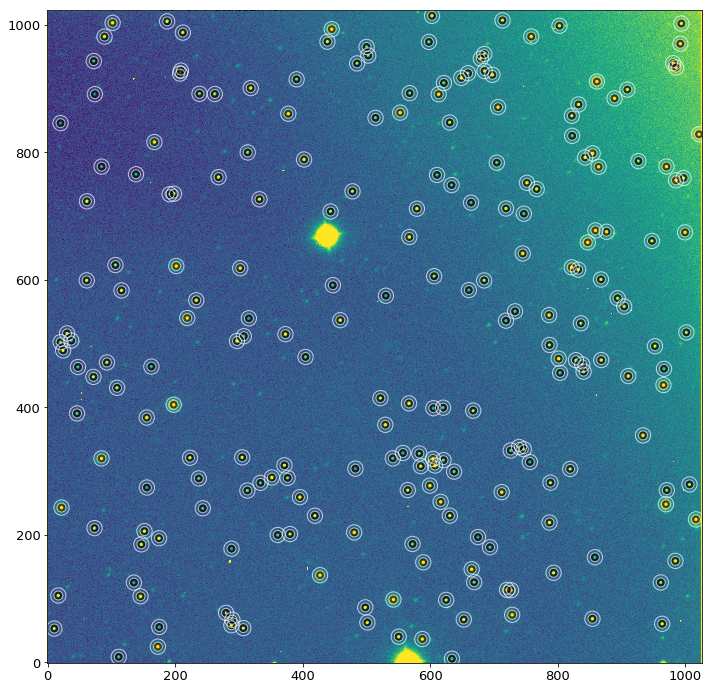

In [9]:
# Plot resultant apertures.

plt.figure(figsize = (12, 12))
plt.imshow(image, cmap = 'viridis', origin = 'lower',
           norm = LogNorm(vmin = bkg_med - 3 * bkg_sigma, vmax = bkg_med + 10 * bkg_sigma))
apertures.plot(color = 'k', lw = 3, alpha = 0.7)
annuli.plot(color = 'w', lw = 1, alpha = 0.7)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13);

In [10]:
# Print the sources.

print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1  634.0249133675072 ...  1.246119963647342 -0.23889963438368758
  2 111.56160913684181 ... 1.4474567224425068 -0.40151396902047043
  3 172.86894581000482 ...   36.8518067877026  -3.9161469637775745
  4  587.5980897548266 ...  18.13192925605412  -3.1461100398419206
  5  550.5983097882797 ...  4.457269493264005  -1.6226722324552914
  6  10.46421469327103 ... 3.4216051609399254  -1.3355747307811985
  7  306.8731201530581 ... 3.8565567159352776  -1.4654993065979731
  8  174.9630691790042 ... 1.2107484252425014  -0.2076347821367547
  9  288.1676820418945 ...  4.026010635004217  -1.5121872944376906
 10  963.7095480887863 ...  4.114835400477571  -1.5358811686799307
...                ... ...                ...                  ...
213   597.998320718491 ... 1.6082997000733346  -0.5159174523869705
214  89.17686334886795 ...  8.831524259042137  -2.365089165558

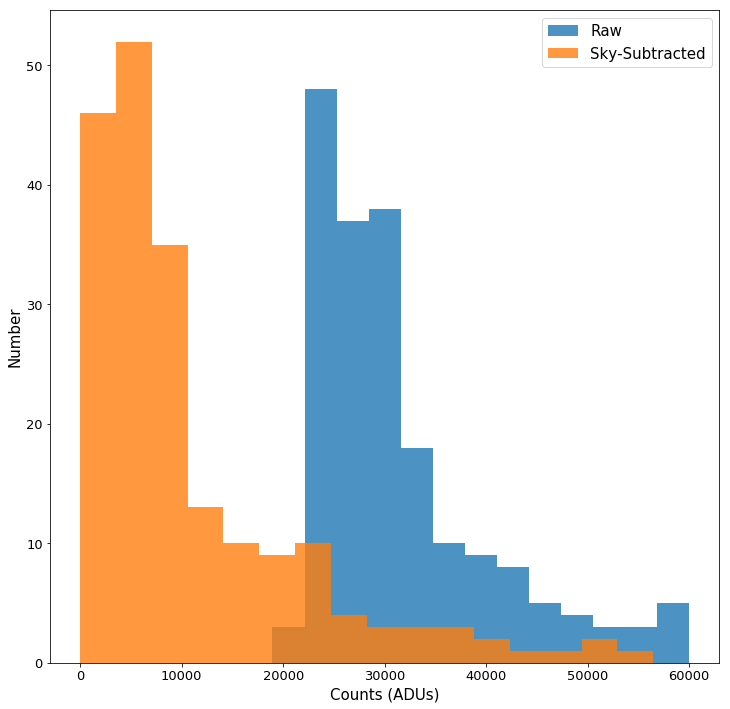

In [60]:
# Calculate and subtract background, then
# plot the results.

bkg_mean = phot_table['aperture_sum_1'] / annuli.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output

plt.figure(figsize = (12, 12))
plt.hist(phot_table['aperture_sum_0'], bins = 'fd', alpha = 0.8, label = 'Raw', 
         range = (0, 60000))
plt.hist(phot_table['residual_aperture_sum'], bins = 'fd', alpha = 0.8, label = 'Sky-Subtracted', 
         range = (0, 60000))
plt.xticks(fontsize = 13)
plt.xlabel('Counts (ADUs)', fontsize = 15)
plt.yticks(fontsize = 13)
plt.ylabel('Number', fontsize = 15)
plt.legend(fontsize = 15);

In [18]:
# Do PSF photometry.

PSF_model = BasicPSFPhotometry(group_maker = DAOGroup(crit_separation = 10), 
                               bkg_estimator = MedianBackground(), 
                               psf_model = IntegratedGaussianPRF(), 
                               finder = DAOStarFinder(fwhm = 5, threshold = 6 * bkg_sigma, 
                                                      exclude_border = True, peakmax = image_max - 1000), 
                               fitshape = 5, 
                               fitter = LevMarLSQFitter())

PSF_phot_table = PSF_model.do_photometry(image)
residual_image = PSF_model.get_residual_image()

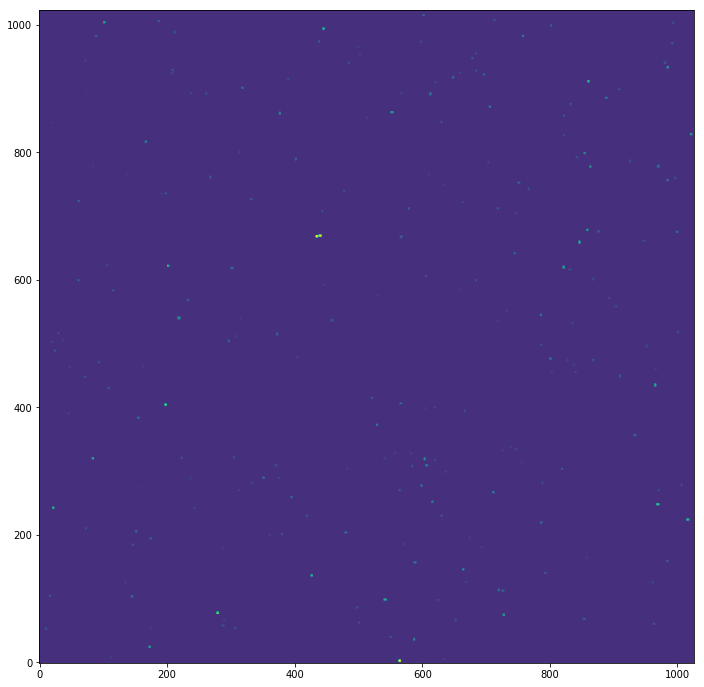

In [46]:
# Plot the final image.

plt.figure(figsize = (12, 12))
plt.imshow(image - residual_image, cmap = 'viridis', origin = 'lower',
           norm = LogNorm(100))

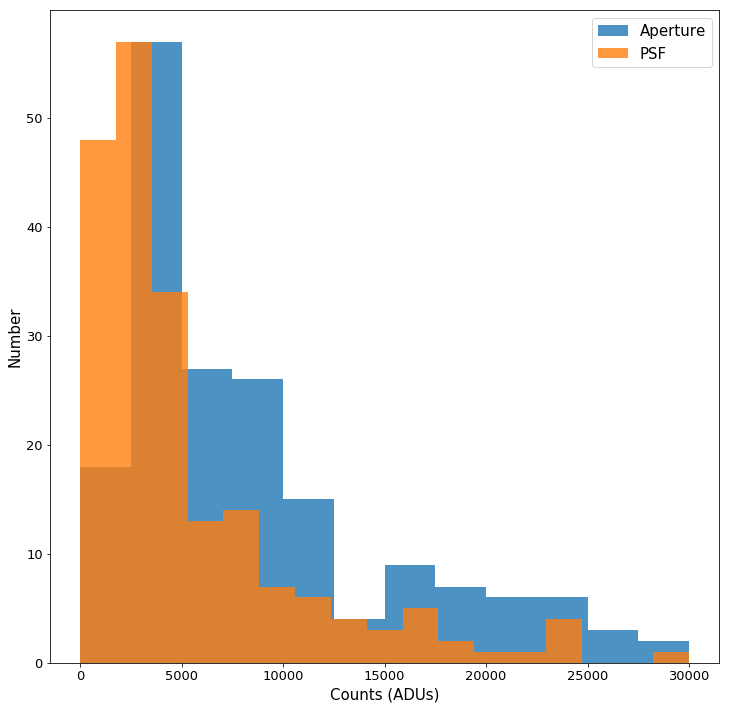

In [62]:
# Plot a comparison of aperture and PSF methods.

plt.figure(figsize = (12, 12))
plt.hist(phot_table['residual_aperture_sum'], bins = 'fd', alpha = 0.8, label = 'Aperture', 
         range = (0, 30000))
plt.hist(PSF_phot_table['flux_fit'], bins = 'fd', alpha = 0.8, label = 'PSF', 
         range = (0, 30000))
plt.xticks(fontsize = 13)
plt.xlabel('Counts (ADUs)', fontsize = 15)
plt.yticks(fontsize = 13)
plt.ylabel('Number', fontsize = 15)
plt.legend(fontsize = 15);